In [132]:
%matplotlib notebook
# Import packages
import h5py
import numpy as np

import sigpy as sp
from sigpy import backend, linop, prox, util
from sigpy.alg import (PowerMethod, GradientMethod,
                       ConjugateGradient, PrimalDualHybridGradient)
import sigpy.plot as pl
import matplotlib.pyplot as plt
import sys
import os

%matplotlib inline
# where to find the file cfl.py
cflpath = "../bart/python"
sys.path.append(os.path.abspath(cflpath))
import cfl
from bart import bart

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# read dataset: brain dataset
h5_dataset_brain = h5py.File('rawdata_brain_radial_96proj_12ch.h5', 'r')

h5_dataset_rawdata_name = list(h5_dataset_brain.keys())[0]
h5_dataset_trajectory_name = list(h5_dataset_brain.keys())[1]

trajectory = h5_dataset_brain.get(h5_dataset_trajectory_name).value
rawdata = h5_dataset_brain.get(h5_dataset_rawdata_name).value

gpu_number = -1 # CPU 

coor = trajectory[:2,:,:].transpose((1,2,0))
coor = sp.backend.to_device(coor,gpu_number)
rawdata_brain = rawdata[0,:,:,:].transpose((2,0,1))
rawdata_brain = sp.backend.to_device(rawdata_brain,gpu_number)

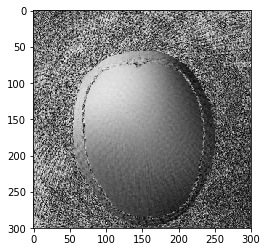

In [4]:
# generating coil sensitivity profiles
image = cfl.readcfl("img_igrid_brain")
image_sos = sp.util.rss(image,3)
sens_maps = image[:,:,0,:]/image_sos
sens_maps_t = sens_maps.transpose((2,0,1))
sens_maps_t = sp.backend.to_device(sens_maps_t,gpu_number)

plt.figure()
plt.imshow(np.abs(sens_maps_t[0,:,:]).reshape(300,300),"gray")

In [36]:
# Modify conjugate gradient algorithm to output a different residual
class ConjugateGradient_rrsg(sp.alg.Alg):
    r"""Conjugate Gradient Method. Solves for:

    .. math:: A x = b

    where A is hermitian.

    Args:
        A (Linop or function): Linop or function to compute A.
        b (array): Observation.
        x (array): Variable.
        P (function or None): Preconditioner.
        max_iter (int): Maximum number of iterations.
        tol (float): Tolerance for stopping condition.

    """

    def __init__(self, A, b, x, P=None, max_iter=100, tol=0):
        self.A = A
        self.P = P
        self.x = x
        self.b = b
        self.tol = tol
        self.device = backend.get_device(x)
        with self.device:
            xp = self.device.xp
            self.r = b - self.A(self.x)
#             self.r = A.H*b - self.A.H(self.A(self.x))

            if self.P is None:
                z = self.r
            else:
                z = self.P(self.r)

            if max_iter > 1:
                self.p = z.copy()
            else:
                self.p = z

            self.not_positive_definite = False
            self.rzold = xp.real(xp.vdot(self.r, z))
#             self.resid = self.rzold.item()**0.5
            self.resid = util.norm2(A.H*b - self.A.H(self.A(self.x)))/util.norm2(self.A.H(self.b))
        super().__init__(max_iter)


    def _update(self):
        with self.device:
            xp = self.device.xp
            Ap = self.A(self.p)
            pAp = xp.real(xp.vdot(self.p, Ap)).item()
            if pAp <= 0:
                self.not_positive_definite = True
                return

            self.alpha = self.rzold / pAp
            util.axpy(self.x, self.alpha, self.p)
            if self.iter < self.max_iter - 1:
                util.axpy(self.r, -self.alpha, Ap)
                if self.P is not None:
                    z = self.P(self.r)
                else:
                    z = self.r

                rznew = xp.real(xp.vdot(self.r, z))
                beta = rznew / self.rzold
                util.xpay(self.p, beta, z)
                self.rzold = rznew
                
#             self.resid = util.norm2(self.r)/util.norm2(self.A.H(self.b))
            self.resid = self.rzold.item()**0.5

    def _done(self):
        return (self.iter >= self.max_iter or
                self.not_positive_definite or self.resid <= self.tol)


In [34]:
# Build a sigpy app that takes a referenz image and computes difference in each iteration
class LinearLeastSquares_ref(sp.app.LinearLeastSquares):
    def __init__(self, A, y, x=None, proxg=None,
                 lamda=0, G=None, g=None, R=None, mu=0, z=0,
                 alg_name=None, max_iter=100,
                 P=None, alpha=None, max_power_iter=30, accelerate=True,
                 tau=None, sigma=None,
                 save_objective_values=True, show_pbar=True, reference_image=None, save_res=True):
        self.A = A
        self.y = y
        self.x = x
        self.proxg = proxg
        self.lamda = lamda
        self.G = G
        self.g = g
        self.R = R
        self.mu = mu
        self.z = z
        self.alg_name = alg_name
        self.max_iter = max_iter
        self.P = P
        self.alpha = alpha
        self.max_power_iter = max_power_iter
        self.accelerate = accelerate
        self.tau = tau
        self.sigma = sigma
        self.save_objective_values = save_objective_values
        self.show_pbar = show_pbar
        self.reference_image = reference_image
        self.save_res = save_res
        
        self.y_device = backend.get_device(y)
        if self.x is None:
            with self.y_device:
                self.x = self.y_device.xp.zeros(A.ishape, dtype=y.dtype)

        self.x_device = backend.get_device(self.x)
#         self._get_alg()
        self._get_ConjugateGradient_rrsg()
        
        if self.save_objective_values:
            self.objective_values = []
        
        if self.save_res:
            self.res = [] # residual
            
        if self.reference_image is not None:
            self.diff_to_reference = []

    def get_diff_to_reference(self):
        with self.y_device:
            r = self.x - self.reference_image
            diff = self.y_device.xp.linalg.norm(r)
        return util.asscalar(diff)
            
    def _summarize(self):
        if self.save_objective_values:
            self.objective_values.append(self.objective())
        
        if self.save_res:
            self.res.append(self.alg.resid)
            
        if self.reference_image is not None:
            self.diff_to_reference.append(self.get_diff_to_reference())
            
        if self.show_pbar:
            if self.save_objective_values:
                self.pbar.set_postfix(
                    obj='{0:.2E}'.format(self.objective_values[-1]))
            else:
                self.pbar.set_postfix(resid='{0:.2E}'.format(self.alg.resid))        
    
    def _get_ConjugateGradient_rrsg(self):
        I = linop.Identity(self.x.shape)
        AHA = self.A.H * self.A
        AHy = self.A.H(self.y)

        if self.lamda != 0:
            if self.R is None:
                AHA += self.lamda * I
            else:
                AHA += self.lamda * self.R.H * self.R

        if self.mu != 0:
            AHA += self.mu * I
            util.axpy(AHy, self.mu, self.z)
        
#         self.alg = sp.alg.ConjugateGradient(
#             AHA, AHy, self.x, P=self.P, max_iter=self.max_iter)

        self.alg = ConjugateGradient_rrsg(
            AHA, AHy, self.x, P=self.P, max_iter=self.max_iter)

            
    def _post_update(self):

        return
        



(array([], dtype=int64), array([], dtype=int64))
E output shape = [12, 512, 96]
DCF shape = (512, 96)
A input shape = [1, 300, 300]
A output shape = [12, 512, 96]


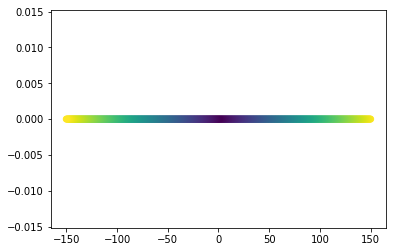

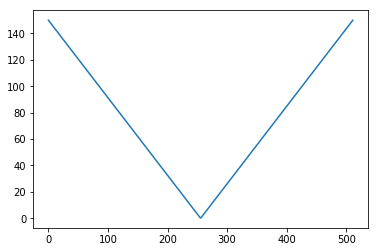

In [37]:
# Define density compensation
def get_dcf(coor):
    dcf = np.linalg.norm(coor,axis=2)
    ind = np.where(dcf == 0)
    dcf[ind] = dcf[ind[0]+1, ind[1]]*1/8
    return dcf

# Compose linear operators
img_shape = (1,300,300)
S = sp.linop.Multiply(img_shape,sens_maps_t)
NUFFT = sp.linop.NUFFT(S.oshape,coor)
E = NUFFT*S
dcf = get_dcf(coor)

plt.figure()
plt.scatter(coor[:,0,0],coor[:,0,1],c=dcf[:,0])
plt.figure()
plt.plot(dcf[:,0])

D = sp.linop.Multiply(E.oshape,np.sqrt(dcf))
A = D*E
print("E output shape = {}".format(E.oshape))
print("DCF shape = {}".format(dcf.shape))
print("A input shape = {}".format(A.ishape))
print("A output shape = {}".format(A.oshape))


In [38]:
s = LinearLeastSquares_ref(A,D*rawdata_brain,max_iter=10)
img_rec_iter10 = s.run()
img_rec_iter10_gpu = sp.backend.to_device(img_rec_iter10,gpu_number)


LinearLeastSquares_ref: 100%|██████████| 10/10 [00:02<00:00,  3.46it/s, obj=8.40E-04]


In [39]:
s = LinearLeastSquares_ref(A,D*rawdata_brain,max_iter=20,reference_image=img_rec_iter10_gpu)
img_rec_now = s.run()

LinearLeastSquares_ref: 100%|██████████| 20/20 [00:05<00:00,  3.47it/s, obj=8.40E-04]


/Users/sanand/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


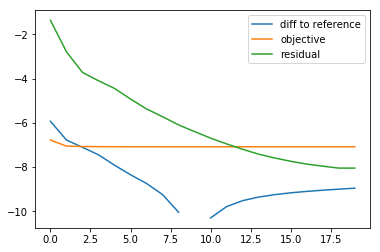

In [40]:
plt.figure()
plt.plot(np.log(s.diff_to_reference),label='diff to reference')
plt.plot(np.log(s.objective_values),label='objective')
plt.plot(np.log(s.res),label="residual")
plt.legend()
plt.show()

(300, 300)


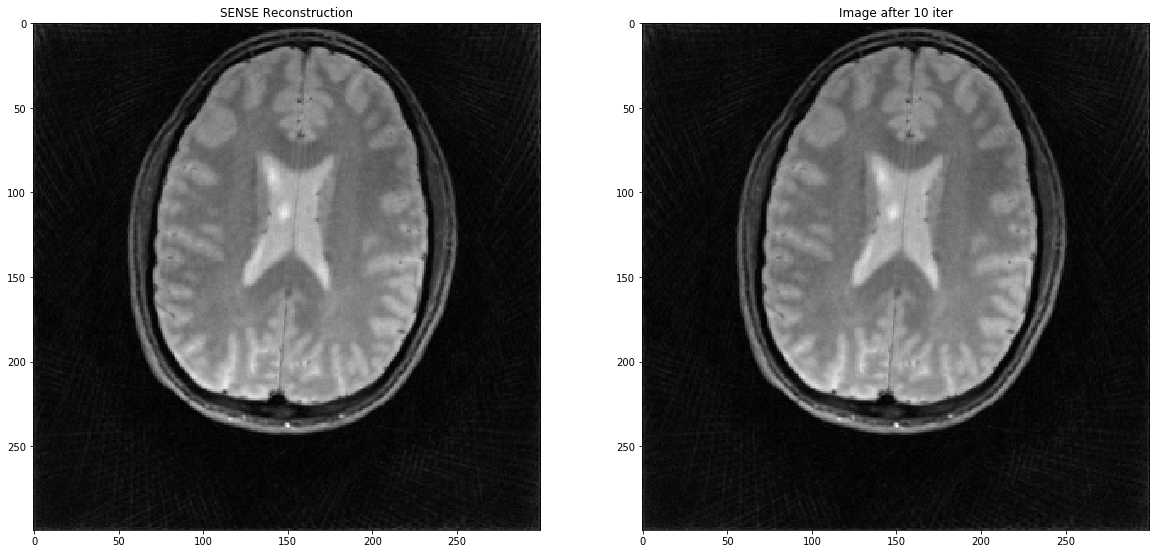

In [41]:
img_rec_now = sp.backend.to_device(img_rec_now)
im_abs_recon_now = abs(img_rec_now[0,:,:])
print(im_abs_recon_now.shape)
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title("SENSE Reconstruction")
plt.imshow(im_abs_recon_now[::-1,:],cmap='gray')


# plt.figure(figsize=(20,10))
plt.subplot(1,2,2)
plt.title("Image after 10 iter")
img_10_abs = np.abs(img_rec_iter10).reshape(300,300)
plt.imshow(img_10_abs[::-1,:],"gray")
plt.show()


ksp = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img_rec_now[0,:,:])))
# plt.figure(figsize=(20,10))
# plt.imshow(np.abs(ksp**(1/3)),"gray")
# %matplotlib notebook
# pl.ImagePlot(ksp)

(array([], dtype=int64), array([], dtype=int64))



LinearLeastSquares_ref: 100%|██████████| 20/20 [00:04<00:00,  4.33it/s, obj=1.41E-04]


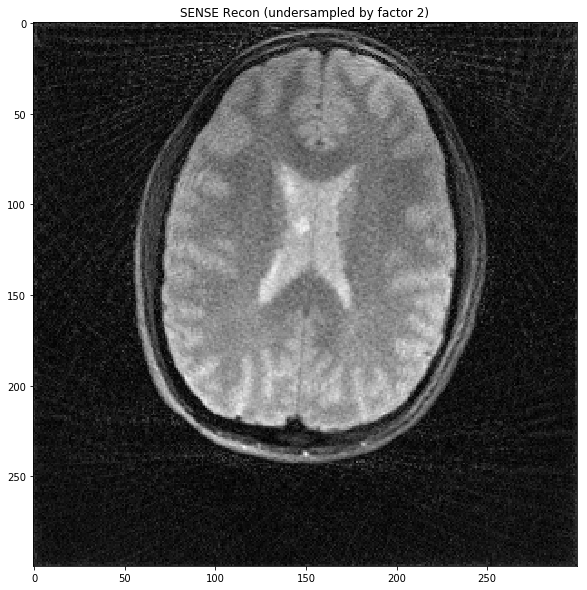

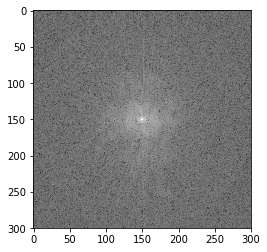

In [74]:
# Undersample
img_shape = (1,300,300)
under = 2
rawdata_brain_2 = rawdata_brain[:,:,::under]
coor_subsample_2 = coor[:,::under,:]
S_2 = sp.linop.Multiply(img_shape,sens_maps_t)
NUFFT_2 = sp.linop.NUFFT(S.oshape,coor_subsample_2)
E_2 = NUFFT_2*S_2
dcf_2 = get_dcf(coor_subsample_2)
D_2 = sp.linop.Multiply(E_2.oshape,np.sqrt(dcf_2))
# D_2 = sp.linop.Multiply(E_2.oshape,np.ones(dcf_2.shape))
A_2 = D_2*E_2
# A_2 = E_2

img_subsample_2 = LinearLeastSquares_ref(A_2,D_2*rawdata_brain_2,max_iter=20).run()
abs_img_subsample_2 = abs(img_subsample_2[0,:,:])
plt.figure(figsize=(20,10))
plt.title("SENSE Recon (undersampled by factor %d)"%under)
plt.imshow(abs_img_subsample_2[::-1,:],cmap='gray')
plt.show()

ksp = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img_subsample_2[0,:,:])))
plt.imshow(np.log(np.abs(ksp)),"gray")

In [116]:
def recon_img(ksp, coord, sens_maps, under, img_shape, ref_img, niter):
    ''' Reconstruct image and plot convergence speed and residual'''
    ksp_under = ksp[:,:,::under]
    coord_under = coord[:,::under,:]
    S = sp.linop.Multiply(img_shape,sens_maps)
    NUFFT = sp.linop.NUFFT(S.oshape,coord_under)
    E = NUFFT*S
    dcf = get_dcf(coord_under)
    D = sp.linop.Multiply(E.oshape,np.sqrt(dcf))
    A = D*E
    s = LinearLeastSquares_ref(A, D*ksp_under, reference_image=ref_img, max_iter=niter, show_pbar=False)
    img = s.run()
    
    # Stats
    diff = s.diff_to_reference
    obj = s.objective_values
    res = s.res
    
    return (img, diff, obj, res)

def gridding(ksp,coord,under, img_shape):
    ''' Reconstruct image with gridding '''
    ksp_under = ksp[:,::under]
    coord_under = coord[:,::under,:]
    dcf = get_dcf(coord_under)
    ksp_dcf = ksp_under*dcf
    NUFFT = sp.linop.NUFFT(img_shape,coord_under)
    niter = 1
    s = LinearLeastSquares_ref(NUFFT, ksp_dcf, max_iter=niter, show_pbar=False)
    img = s.run()
    
    return img

# kspace filter
def fft2c(x):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x)))

def ifft2c(y):
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(y)))


def filter(img):
#     ksp = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(img)))
    ksp = fft2c(img)
    kxmax = ksp.shape[0]
    kymax = ksp.shape[1]
    kx = np.arange(-kxmax/2, kxmax/2)
    ky = np.arange(-kymax/2, kymax/2)
    xx, yy = np.meshgrid(kx, ky)
    kc = kxmax/2
    k = np.sqrt(xx**2 + yy**2)
    beta = 100
    filt = 0.5 + 1/np.pi * np.arctan(beta*(kc - k)/kc)
    
    filt_ksp = filt*ksp
    img_filt = ifft2c(filt_ksp)
    
    return (filt, img_filt, filt_ksp)

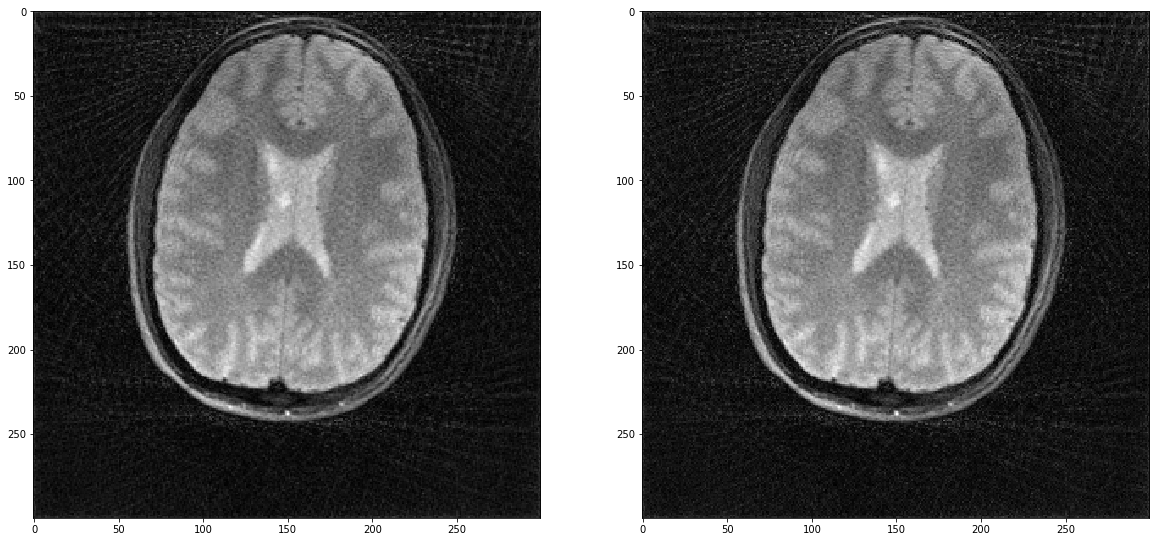

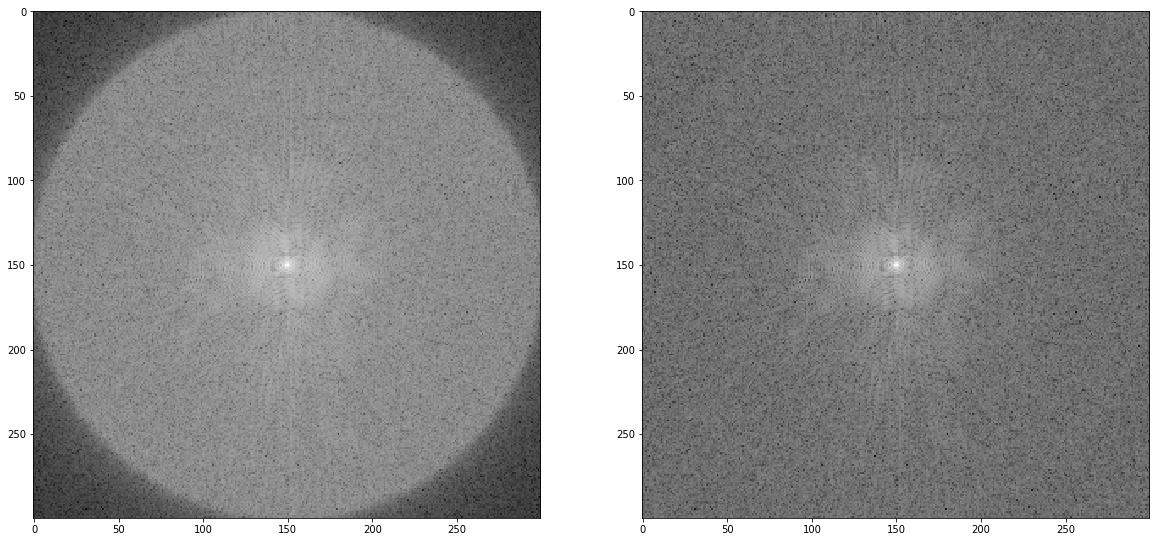

In [117]:
filt, img_filt, filt_ksp = filter(img_subsample_2[0,:,:])
img_filt_abs = np.abs(img_filt)
img_abs = np.abs(img_subsample_2[0,:,:])
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(img_filt_abs[::-1,:],"gray")
plt.subplot(1,2,2)
plt.imshow(img_abs[::-1,:],"gray")


ksp = fft2c(img_subsample_2[0,:,:])
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.imshow(np.log(np.abs(filt*ksp)),"gray")
plt.subplot(1,2,2)
plt.imshow(np.log(np.abs(ksp)),"gray")





(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


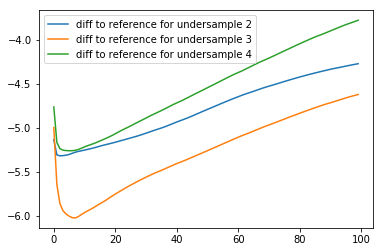

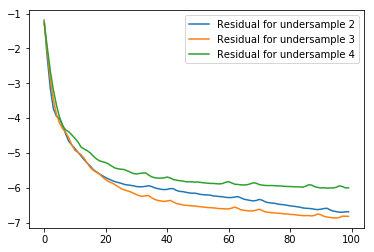

In [88]:
# Reproduce figure 4
img_shape = (1,300,300)
factors = [2,3,4]
niter = 100
diffs = np.zeros((len(factors),niter))
resids = np.zeros((len(factors),niter))
for f in factors:
    img, diff, obj, res = recon_img(rawdata_brain,
                                    coor,sens_maps_t,
                                    f,img_shape,
                                    img_rec_now, niter)
    diffs[f-2,:] = diff
    resids[f-2,:] = res

# Figure 4a
plt.figure()
for i in range(diffs.shape[0]):
    plt.plot(np.log(diffs[i,:]),label='diff to reference for undersample ' + str(factors[i]))
    plt.legend()
plt.show()

# Figure 4b
plt.figure()
for i in range(resids.shape[0]):
    plt.plot(np.log(resids[i,:]),label='Residual for undersample ' + str(factors[i]))
    plt.legend()
plt.show()

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


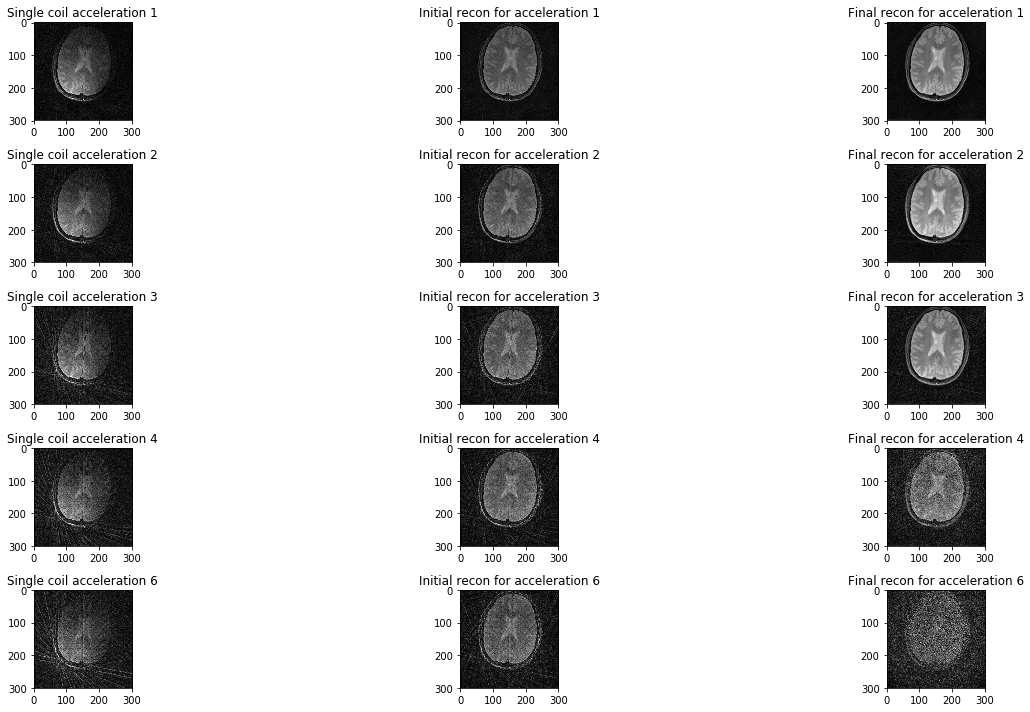

In [128]:
# Reproduce Figure 5
factors = [1,2,3,4,6]
img_shape = (300,300)
plt.figure(figsize=(20,10))
grid_ctr = 1
sense_ctr = 2
final_ctr = 3
niters = [3,6,15,50,99]
N = len(factors)

for i in range(N):
    # Gridding plot
    img_grid = gridding(rawdata_brain[0,:,:],coor,factors[i],img_shape)
    img_abs = np.abs(img_grid)
    ax1 = plt.subplot(N,3,grid_ctr)
    ax1.set_title("Single coil acceleration " + str(factors[i]))
    plt.imshow(img_abs[::-1,:],"gray")
    grid_ctr += 3
    
    # SENSE recon plot
    niter = 1
    img, diff, obj, res = recon_img(rawdata_brain,
                                    coor,sens_maps_t,
                                    factors[i],img_shape,
                                    img_rec_now, niter)
    img_abs = np.abs(img)
    ax2 = plt.subplot(N,3,sense_ctr)
    ax2.set_title("Initial recon for acceleration " + str(factors[i]))
    plt.imshow(img_abs[::-1,:],"gray")
    sense_ctr += 3
    
    # final SENSE recon plot
    niter = niters[i]
    img, diff, obj, res = recon_img(rawdata_brain,
                                    coor,sens_maps_t,
                                    factors[i],img_shape,
                                    img_rec_now, niter)
    img_abs = np.abs(img)
    ax3= plt.subplot(N,3,final_ctr)
    ax3.set_title("Final recon for acceleration "+ str(factors[i]))
    plt.imshow(img_abs[::-1,:],"gray")
    final_ctr += 3
    
plt.tight_layout()
plt.show()

/Users/sanand/miniconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:2390: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(add.reduce(s, axis=axis, keepdims=keepdims))


(array([160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
       160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
       160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
       160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160, 160,
       160, 160, 160]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54]))


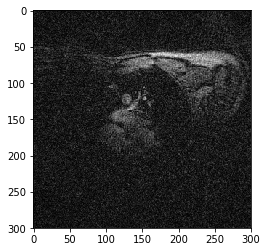

In [146]:
# Reproduce Figure 6
# read dataset: heart dataset
h5_dataset_heart = h5py.File('rawdata_heart_radial_55proj_34ch.h5', 'r')

h5_dataset_rawdata_name = list(h5_dataset_heart.keys())[0]
h5_dataset_trajectory_name = list(h5_dataset_heart.keys())[1]

trajectory = h5_dataset_heart.get(h5_dataset_trajectory_name).value
rawdata = h5_dataset_heart.get(h5_dataset_rawdata_name).value
coor = trajectory[:2,:,:].transpose((1,2,0))
coor = sp.backend.to_device(coor,gpu_number)
rawdata_heart = rawdata[0,:,:,:].transpose((2,0,1))

img_grid = gridding(rawdata_heart,coor,1,(34,300,300))
plt.figure()
plt.imshow(np.abs(img_grid[1,:,:]),"gray")

# Grid to get maps
# img_igrid = bart(1, 'nufft -i -t', trajectory, rawdata)

# # channel combination
# img_igrid_sos = bart(1, 'rss 8', img_igrid)
# img_igrid_sos = np.abs(img_igrid_sos)
# sens_maps = img_igrid[:,:,0,:]/img_igrid_sos
# sens_maps_t = sens_maps.transpose((2,0,1))

# gpu_number = -1 # CPU 




# print("Heart ksp shape = {}".format(rawdata_heart.shape))
# print("Heart coordinate shape = {}".format(coor.shape))

# # Reconstruct
# nproj = [55, 33, 22, 11] 
# for i in range(N):
#     # SENSE recon plot
#     niter = 10
#     img, diff, obj, res = recon_img(rawdata_heart,
#                                     coor,sens_maps_t,
#                                     factors[i],img_shape,
#                                     img_rec_now, niter)
#     img_abs = np.abs(img)
#     ax2 = plt.subplot(N,3,sense_ctr)
#     ax2.set_title("Initial recon for acceleration " + str(factors[i]))
#     plt.imshow(img_abs[::-1,:],"gray")
#     sense_ctr += 3
    
#     # final SENSE recon plot
#     niter = niters[i]
#     img, diff, obj, res = recon_img(rawdata_brain,
#                                     coor,sens_maps_t,
#                                     factors[i],img_shape,
#                                     img_rec_now, niter)
#     img_abs = np.abs(img)
#     ax3= plt.subplot(N,3,final_ctr)
#     ax3.set_title("Final recon for acceleration "+ str(factors[i]))
#     plt.imshow(img_abs[::-1,:],"gray")
#     final_ctr += 3
    
# plt.tight_layout()
# plt.show()

SyntaxError: invalid syntax (<ipython-input-140-93b4dd74f448>, line 1)